[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kalagat23\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


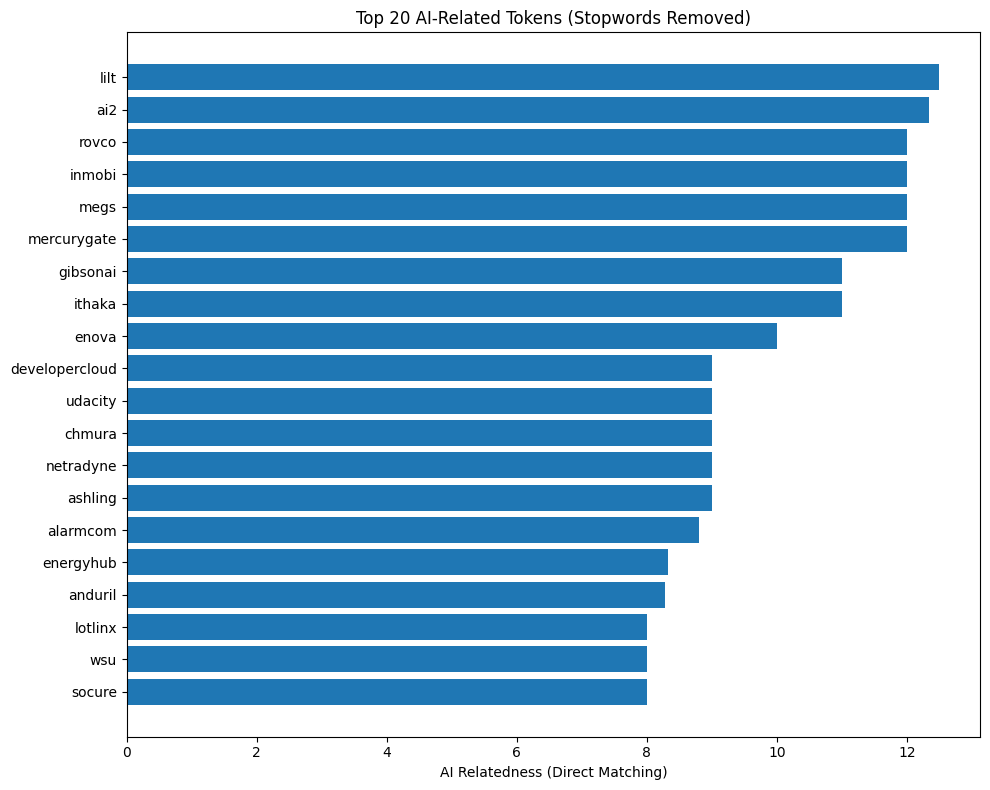

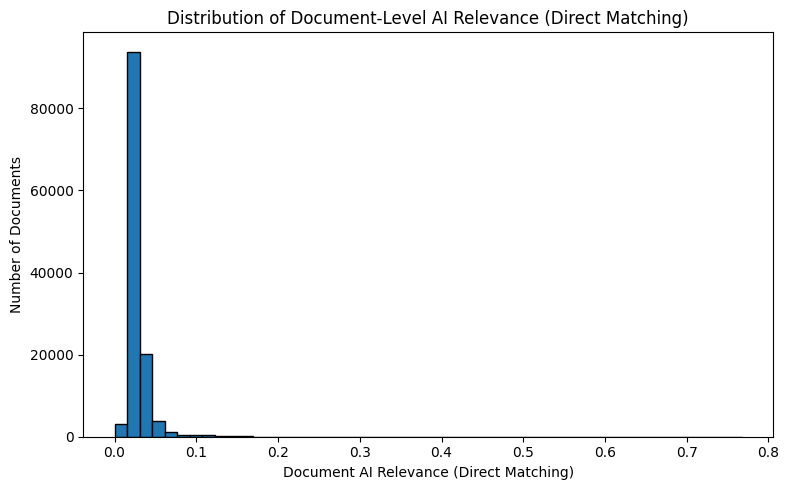

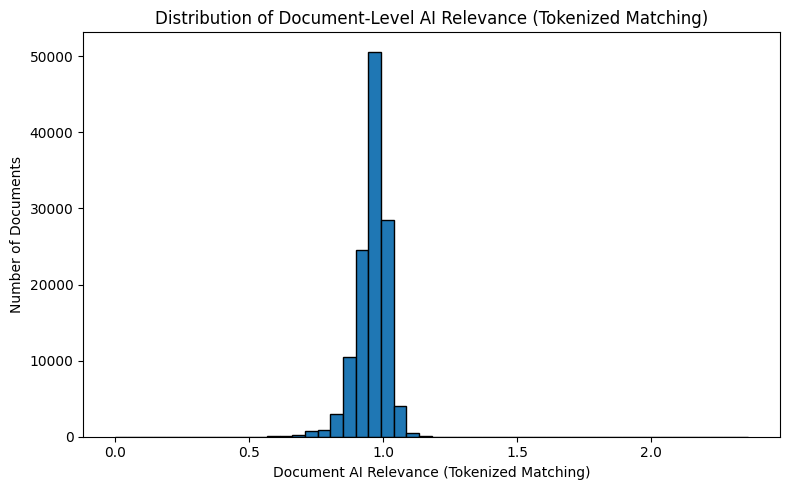

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
nltk.download('stopwords')

# -------------------------------
# 1. Load and Preprocess the Data
# -------------------------------
# Read the CSV file (ensure the file "postings.csv" has the given columns)
df = pd.read_csv("postings.csv")

# Combine text fields from 'description' and 'skills_desc'
df['combined_text'] = df['description'].fillna('') + " " + df['skills_desc'].fillna('')

# Clean text: convert to lower-case and remove punctuation
def clean_text(t):
    return re.sub(r"[^\w\s]", "", t.lower()) if pd.notnull(t) else ""
df['clean_text'] = df['combined_text'].apply(clean_text)

# -------------------------------
# 2. Build the Document-Token Matrix
# -------------------------------
# Use CountVectorizer with stopwords removed
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=1)
X = vectorizer.fit_transform(df['clean_text'])
tokens = vectorizer.get_feature_names_out()
occurrence = X.getnnz(axis=0)

# --------------------------------------------
# 3. Define Core AI Skills and Compute Measures
# --------------------------------------------
# Define core AI skills as phrases
core_ai = ["machine learning", "computer vision", "natural language processing"]

# --- Direct Matching Approach: Check for full phrase presence ---
def has_core_phrase(text, phrases):
    # Return 1 if any full core AI phrase is found in the text
    return int(any(phrase in text for phrase in phrases))

df['has_core_direct'] = df['clean_text'].apply(lambda t: has_core_phrase(t, core_ai))
doc_has_core_direct = df['has_core_direct'].values.reshape(-1, 1)

# Compute token co-occurrence counts with the core AI phrases (direct matching)
co_occurrence_direct = np.array(X.T.dot(doc_has_core_direct)).flatten()
with np.errstate(divide='ignore', invalid='ignore'):
    A_direct = np.true_divide(co_occurrence_direct, occurrence)
    A_direct[occurrence == 0] = 0

# --- Tokenized Matching Approach: Split phrases into tokens ---
normalize = lambda t: re.sub(r"[^\w\s]", "", t.lower()) if pd.notnull(t) else ""
core_ai_tokens = set()
for phrase in core_ai:
    core_ai_tokens.update(normalize(phrase).split())

def has_core_tokens(text, token_set):
    doc_tokens = set(text.split())
    return int(len(doc_tokens.intersection(token_set)) > 0)

df['has_core_tokenized'] = df['clean_text'].apply(lambda t: has_core_tokens(t, core_ai_tokens))
doc_has_core_tokenized = df['has_core_tokenized'].values.reshape(-1, 1)

# Compute token co-occurrence counts for tokenized matching
co_occurrence_tokenized = np.array(X.T.dot(doc_has_core_tokenized)).flatten()
with np.errstate(divide='ignore', invalid='ignore'):
    A_tokenized = np.true_divide(co_occurrence_tokenized, occurrence)
    A_tokenized[occurrence == 0] = 0

# Create a DataFrame of tokens and their AI-relatedness scores for inspection
tokens_df = pd.DataFrame({
    'token': tokens,
    'occurrence': occurrence,
    'co_occurrence_direct': co_occurrence_direct,
    'ai_relatedness_direct': A_direct,
    'co_occurrence_tokenized': co_occurrence_tokenized,
    'ai_relatedness_tokenized': A_tokenized
})

# -------------------------------
# 4. Compute Document-Level AI Relevance Scores
# -------------------------------
# Binarize the document-token matrix (each token counts as present or not)
X_bin = X.copy()
X_bin.data = np.ones_like(X_bin.data)
doc_token_count = np.array(X_bin.sum(axis=1)).flatten()

# Document-level score using direct matching
doc_score_sum_direct = np.array(X_bin.dot(A_direct)).flatten()
doc_avg_direct = np.divide(doc_score_sum_direct, doc_token_count, out=np.zeros_like(doc_score_sum_direct), where=doc_token_count != 0)
df['document_ai_relevance_direct'] = doc_avg_direct

# Document-level score using tokenized matching
doc_score_sum_tokenized = np.array(X_bin.dot(A_tokenized)).flatten()
doc_avg_tokenized = np.divide(doc_score_sum_tokenized, doc_token_count, out=np.zeros_like(doc_score_sum_tokenized), where=doc_token_count != 0)
df['document_ai_relevance_tokenized'] = doc_avg_tokenized

# -----------------------------------------------------------------------------------
# 5. Plot 1: Top Tokens by AI-Relatedness (Stopwords Removed)
# -----------------------------------------------------------------------------------
# Remove stopwords using nltk's stopwords list
stop_words = set(stopwords.words('english'))
filtered_tokens_df = tokens_df[~tokens_df['token'].isin(stop_words)]

# Sort and select top 20 tokens based on direct matching AI-relatedness
top_filtered_tokens = filtered_tokens_df.sort_values('ai_relatedness_direct', ascending=False).head(20)

plt.figure(figsize=(10,8))
plt.barh(top_filtered_tokens['token'][::-1], top_filtered_tokens['ai_relatedness_direct'][::-1])
plt.xlabel('AI Relatedness (Direct Matching)')
plt.title('Top 20 AI-Related Tokens (Stopwords Removed)')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------------
# 6. Plot 2: Distribution of Document-Level AI Relevance Scores
# -----------------------------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(df['document_ai_relevance_direct'], bins=50, edgecolor='k')
plt.xlabel("Document AI Relevance (Direct Matching)")
plt.ylabel("Number of Documents")
plt.title("Distribution of Document-Level AI Relevance (Direct Matching)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df['document_ai_relevance_tokenized'], bins=50, edgecolor='k')
plt.xlabel("Document AI Relevance (Tokenized Matching)")
plt.ylabel("Number of Documents")
plt.title("Distribution of Document-Level AI Relevance (Tokenized Matching)")
plt.tight_layout()
plt.show()



Number of AI-related jobs: 5167
Number of firms offering AI-related jobs: 2007


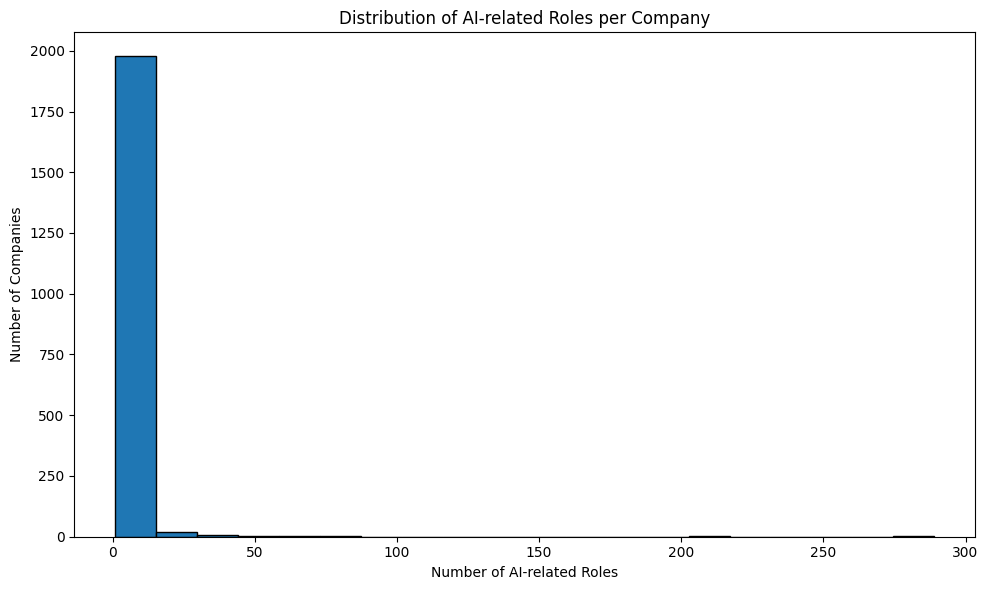

In [5]:
# -----------------------------------------------------------------------------------
# 7. Analysis Based on a User-Defined AI Threshold
# -----------------------------------------------------------------------------------
# Set your desired AI threshold
ai_threshold = 0.05

# Create a binary indicator for AI-related jobs using the direct matching score
df['is_ai_job'] = (df['document_ai_relevance_direct'] > ai_threshold).astype(int)

# Count the number of AI-related jobs
num_ai_jobs = df['is_ai_job'].sum()
print("Number of AI-related jobs:", num_ai_jobs)

# Count the number of unique firms offering AI-related jobs (using "company_name")
num_firms = df.loc[df['is_ai_job'] == 1, 'company_name'].nunique()
print("Number of firms offering AI-related jobs:", num_firms)

# -----------------------------------------------------------------------------------
# 8. Plot 3: Distribution of AI-Related Roles per Firm
# -----------------------------------------------------------------------------------
# Group by company_name to count the number of AI-related roles per firm
ai_roles_per_firm = df.loc[df['is_ai_job'] == 1].groupby('company_name').size()

plt.figure(figsize=(10,6))
if num_firms < 30:
    # Bar chart for a smaller number of firms
    ai_roles_per_firm.sort_values().plot(kind='barh')
    plt.xlabel("Number of AI-related Roles")
    plt.title("AI-related Roles per Company")
else:
    # Histogram for a larger number of firms
    plt.hist(ai_roles_per_firm, bins=20, edgecolor='k')
    plt.xlabel("Number of AI-related Roles")
    plt.ylabel("Number of Companies")
    plt.title("Distribution of AI-related Roles per Company")
plt.tight_layout()
plt.show()


# Using BERT

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch

# -------------------------------
# 1. Load and Preprocess the Data
# -------------------------------
# Read the CSV file (ensure "postings.csv" has 'description' and 'skills_desc')
df = pd.read_csv("postings.csv")

# Combine text fields from 'description' and 'skills_desc'
df['combined_text'] = df['description'].fillna('') + " " + df['skills_desc'].fillna('')

# Clean text: convert to lower-case and remove excessive punctuation
def clean_text(t):
    return re.sub(r"[^\w\s]", "", t.lower()) if pd.notnull(t) else ""
df['clean_text'] = df['combined_text'].apply(clean_text)

# -------------------------------
# 2. Load BERT Model and Tokenizer
# -------------------------------
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to split text into chunks of 500 tokens and get averaged BERT embeddings
def get_averaged_bert_embedding(text, chunk_size=500):
    # Tokenize the full text
    tokens = tokenizer.tokenize(text)
    
    # If the text is shorter than chunk_size, process it directly
    if len(tokens) <= chunk_size:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    
    # Split into chunks of 500 tokens
    token_chunks = [tokens[i:i + chunk_size] for i in range(0, len(tokens), chunk_size)]
    embeddings = []
    
    for chunk in token_chunks:
        # Convert tokens back to text for processing
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        inputs = tokenizer(chunk_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the [CLS] token embedding for each chunk
        embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())
    
    # Average the embeddings across all chunks
    return np.mean(embeddings, axis=0)

# -------------------------------
# 3. Define Core AI Skills and Get Their Embeddings
# -------------------------------
core_ai = ["machine learning", "computer vision", "natural language processing"]

# Get embeddings for core AI phrases (no chunking needed since these are short)
core_ai_embeddings = np.array([get_averaged_bert_embedding(phrase) for phrase in core_ai])
core_ai_mean_embedding = np.mean(core_ai_embeddings, axis=0)  # Average embedding for AI-relatedness

# -------------------------------
# 4. Compute Document-Level AI Relevance Scores
# -------------------------------
# Get averaged embeddings for all documents
document_embeddings = np.array([get_averaged_bert_embedding(text) for text in df['clean_text']])

# Compute cosine similarity between document embeddings and core AI mean embedding
ai_relevance_scores = cosine_similarity(document_embeddings, core_ai_mean_embedding.reshape(1, -1)).flatten()
df['document_ai_relevance_bert'] = ai_relevance_scores



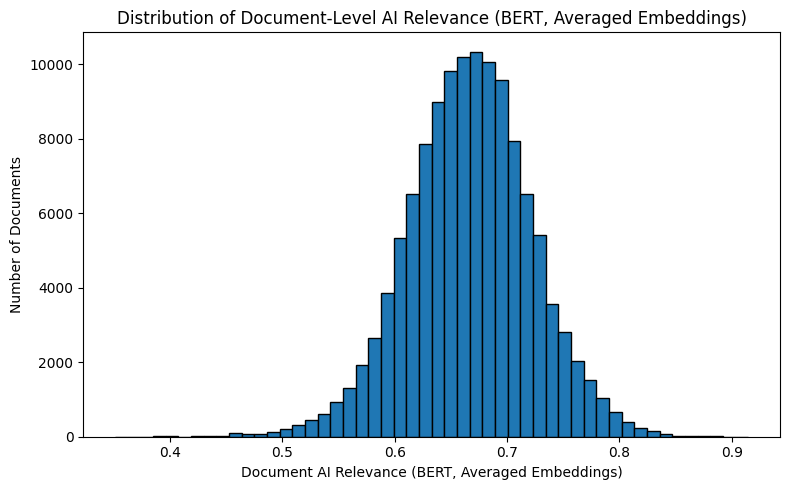

Number of AI-related jobs: 123328
Number of firms offering AI-related jobs: 24348


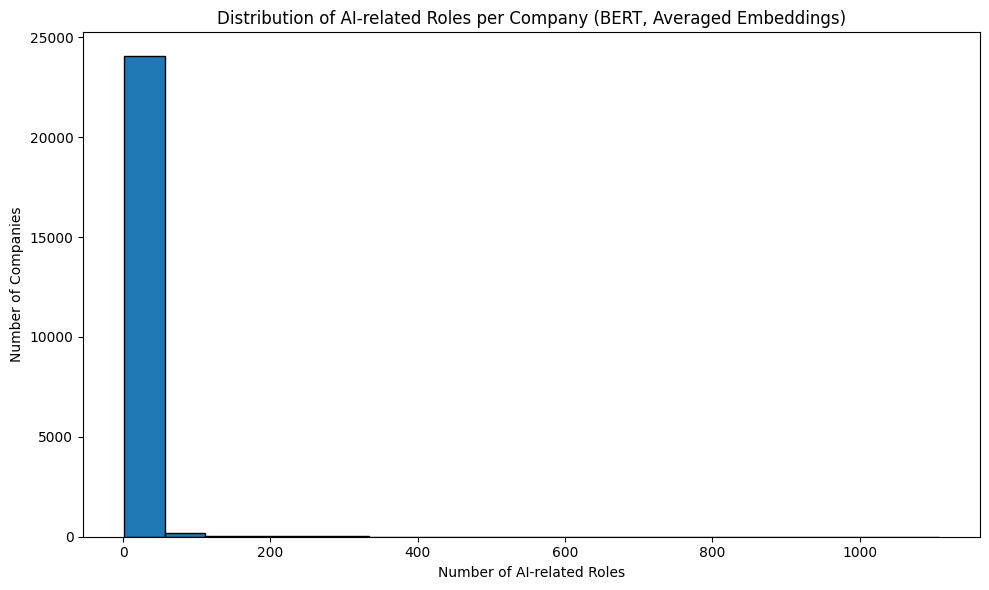

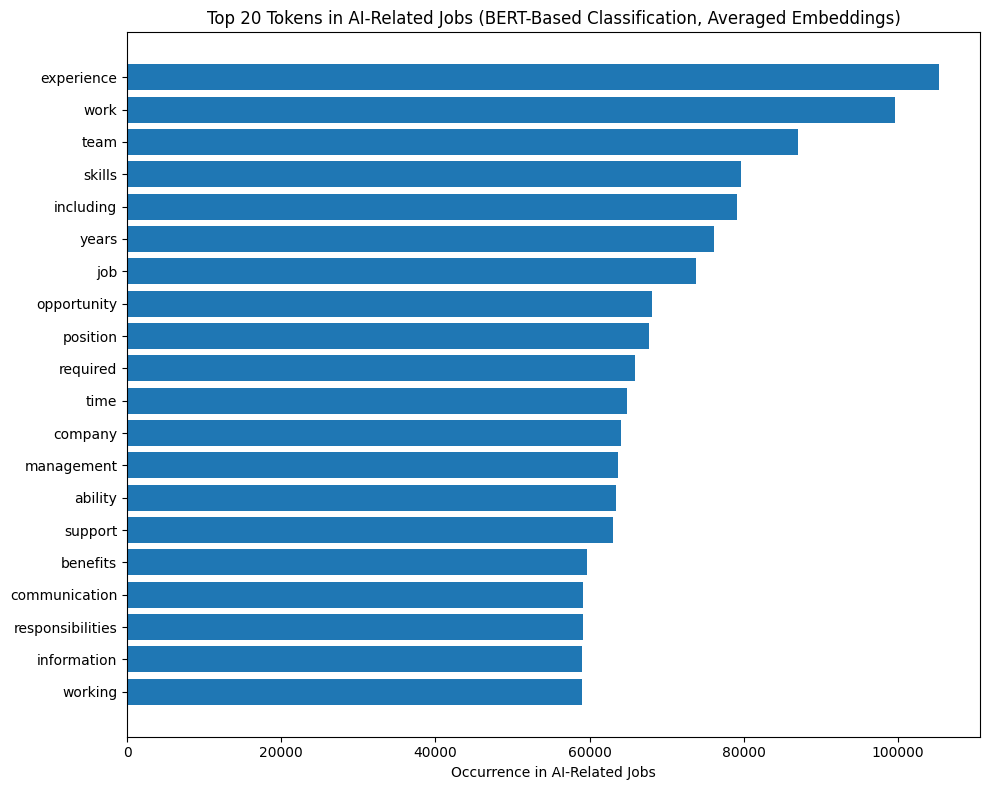

In [3]:
# -------------------------------
# 5. Plot 1: Distribution of Document-Level AI Relevance Scores (BERT)
# -------------------------------
plt.figure(figsize=(8, 5))
plt.hist(df['document_ai_relevance_bert'], bins=50, edgecolor='k')
plt.xlabel("Document AI Relevance (BERT, Averaged Embeddings)")
plt.ylabel("Number of Documents")
plt.title("Distribution of Document-Level AI Relevance (BERT, Averaged Embeddings)")
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Analysis Based on a User-Defined AI Threshold
# -------------------------------
# Set your desired AI threshold (cosine similarity, typically between 0 and 1)
ai_threshold = 0.5  # Adjust based on your data

# Create a binary indicator for AI-related jobs using BERT similarity
df['is_ai_job'] = (df['document_ai_relevance_bert'] > ai_threshold).astype(int)

# Count the number of AI-related jobs
num_ai_jobs = df['is_ai_job'].sum()
print("Number of AI-related jobs:", num_ai_jobs)

# Count the number of unique firms offering AI-related jobs (using "company_name")
num_firms = df.loc[df['is_ai_job'] == 1, 'company_name'].nunique()
print("Number of firms offering AI-related jobs:", num_firms)

# -------------------------------
# 7. Plot 2: Distribution of AI-Related Roles per Firm
# -------------------------------
# Group by company_name to count the number of AI-related roles per firm
ai_roles_per_firm = df.loc[df['is_ai_job'] == 1].groupby('company_name').size()

plt.figure(figsize=(10, 6))
if num_firms < 30:
    # Bar chart for a smaller number of firms
    ai_roles_per_firm.sort_values().plot(kind='barh')
    plt.xlabel("Number of AI-related Roles")
    plt.title("AI-related Roles per Company (BERT, Averaged Embeddings)")
else:
    # Histogram for a larger number of firms
    plt.hist(ai_roles_per_firm, bins=20, edgecolor='k')
    plt.xlabel("Number of AI-related Roles")
    plt.ylabel("Number of Companies")
    plt.title("Distribution of AI-related Roles per Company (BERT, Averaged Embeddings)")
plt.tight_layout()
plt.show()

# -------------------------------
# 8. Optional: Top Tokens Analysis (Approximation with BERT)
# -------------------------------
# Analyze frequent terms in AI-related documents using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words='english', min_df=1)
X = vectorizer.fit_transform(df.loc[df['is_ai_job'] == 1, 'clean_text'])  # Only AI-related docs
tokens = vectorizer.get_feature_names_out()
occurrence = X.getnnz(axis=0)

top_tokens_df = pd.DataFrame({'token': tokens, 'occurrence': occurrence})
top_tokens_df = top_tokens_df.sort_values('occurrence', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(top_tokens_df['token'][::-1], top_tokens_df['occurrence'][::-1])
plt.xlabel('Occurrence in AI-Related Jobs')
plt.title('Top 20 Tokens in AI-Related Jobs (BERT-Based Classification, Averaged Embeddings)')
plt.tight_layout()
plt.show()

In [4]:
df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,work_type,currency,compensation_type,normalized_salary,zip_code,fips,combined_text,clean_text,document_ai_relevance_bert,is_ai_job
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,Job descriptionA leading real estate firm in N...,job descriptiona leading real estate firm in n...,0.564150,1
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0,"At Aspen Therapy and Wellness , we are committ...",at aspen therapy and wellness we are committe...,0.708823,1
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,The National Exemplar is accepting application...,the national exemplar is accepting application...,0.751564,1
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,Senior Associate Attorney - Elder Law / Trusts...,senior associate attorney elder law trusts a...,0.672977,1
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0,Looking for HVAC service tech with experience ...,looking for hvac service tech with experience ...,0.780730,1


Computing embeddings for market_words...
Computing embeddings for operational_words...


Processing chunks: 0it [00:00, ?it/s]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 1it [02:12, 132.14s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 2it [04:36, 139.57s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 3it [07:03, 142.63s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 4it [09:26, 143.01s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 5it [11:43, 140.75s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 6it [14:06, 141.62s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 7it [16:29, 141.97s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 8it [18:53, 142.48s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 9it [21:06, 139.53s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 10it [23:26, 139.89s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 11it [25:47, 140.02s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 12it [28:18, 143.56s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 13it [31:03, 150.07s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 14it [33:40, 152.17s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 15it [35:58, 147.75s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 16it [38:21, 146.35s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 17it [40:51, 147.47s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 18it [43:23, 148.83s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 19it [45:49, 147.88s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 20it [48:12, 146.60s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 21it [50:36, 145.81s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 22it [53:07, 147.35s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 23it [55:33, 146.88s/it]

Chunk size: 5000, Sampled size: 2000


Processing chunks: 24it [57:52, 144.51s/it]

Chunk size: 3849, Sampled size: 1540


Processing chunks: 25it [59:52, 143.71s/it]

Total sampled jobs processed: 49540
Total sampled jobs: 49540, Jobs with AI similarity >= 0.7: 13117


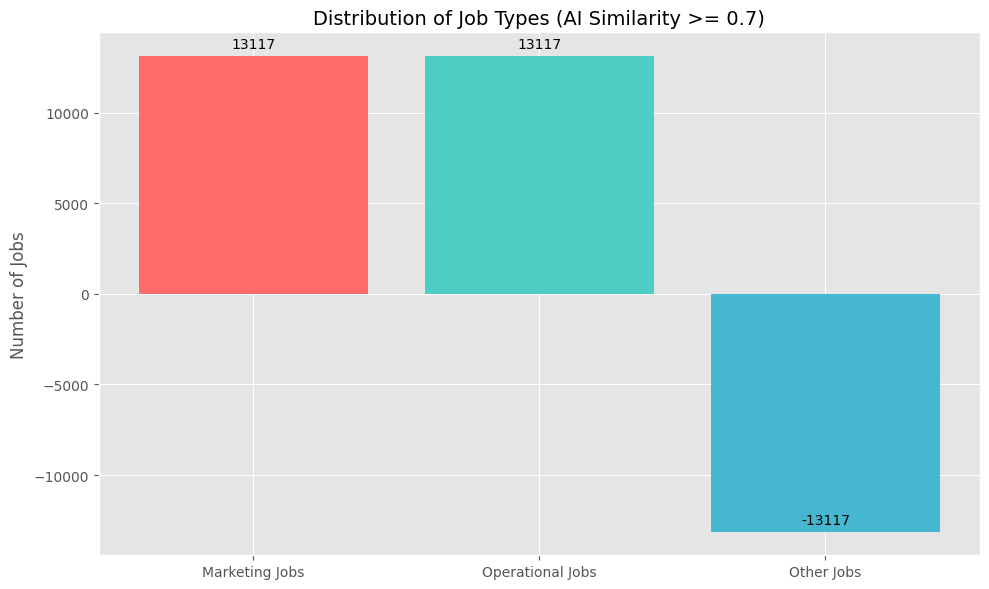

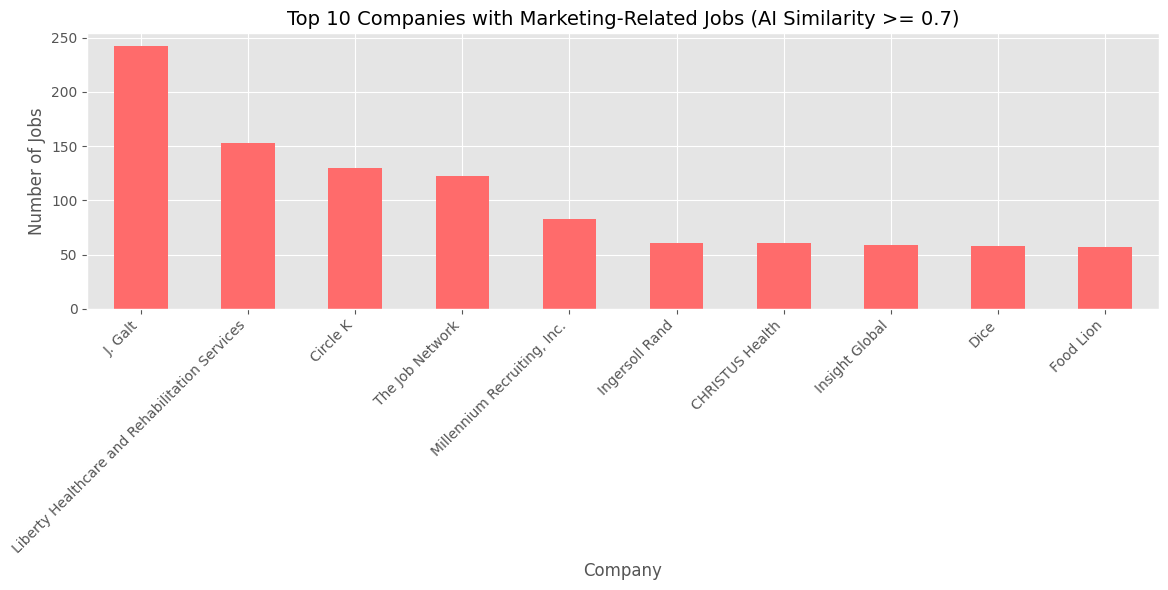

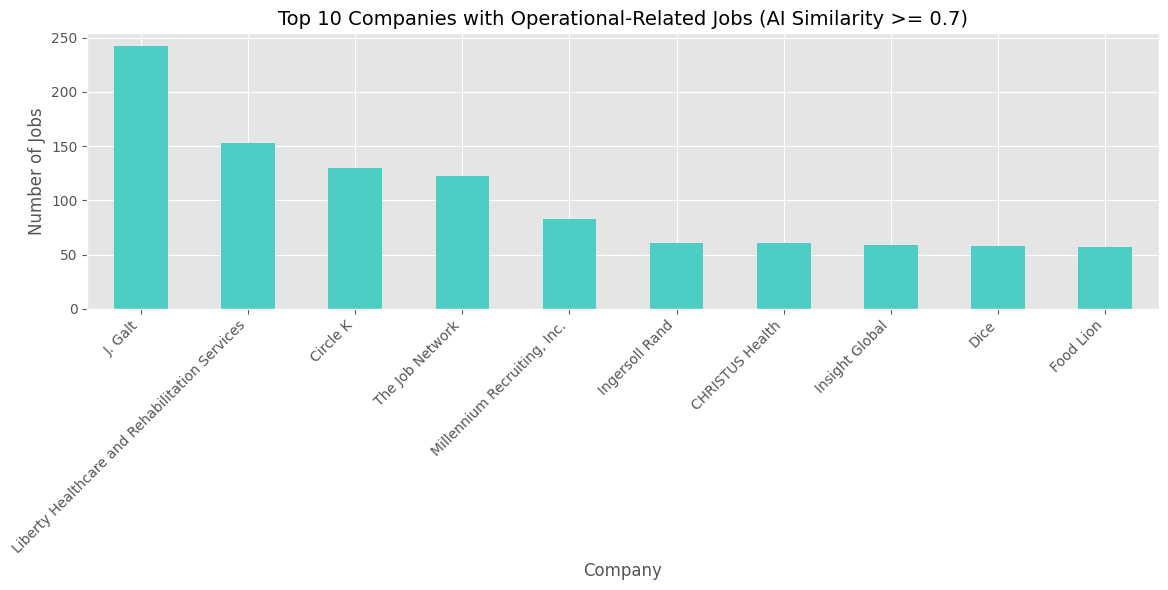

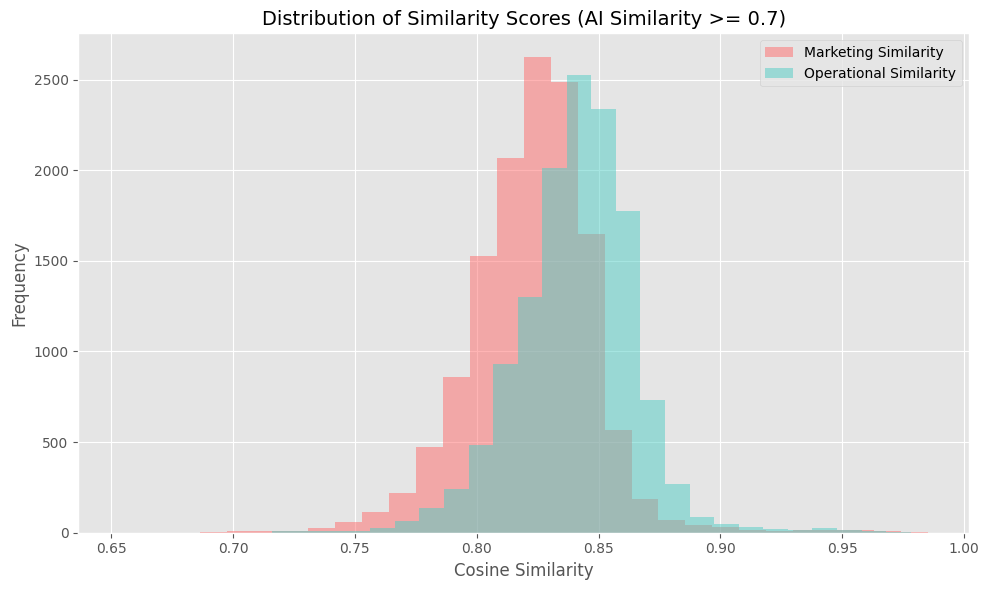

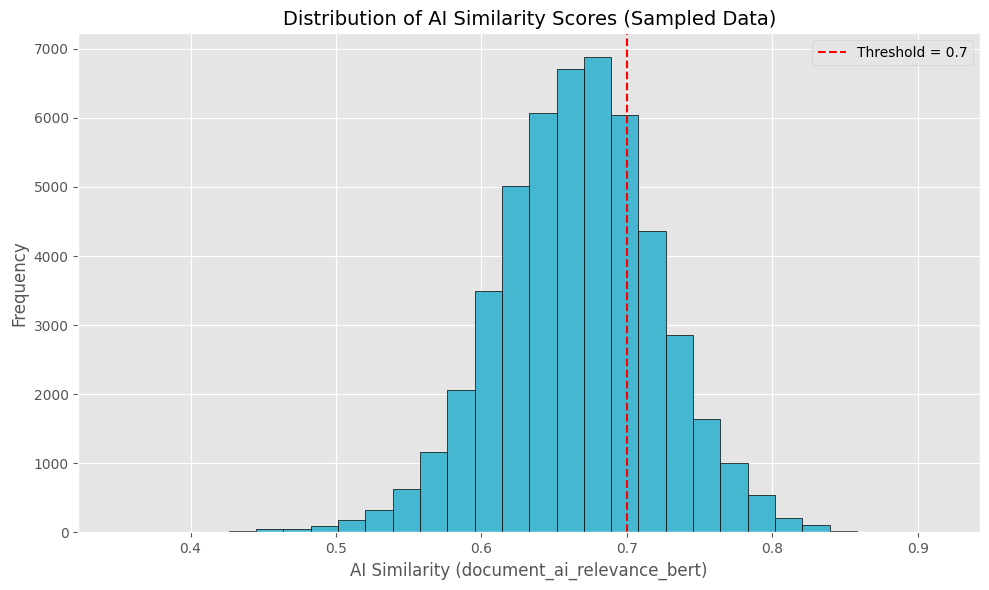

Processing complete. Sampled results saved to 'job_similarity_results_sampled.csv'


In [ ]:
# Cell 1: Imports and Setup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm
import gc

plt.style.use('ggplot')  # Set ggplot style for plots

# Cell 2: Helper Functions
# Memory-efficient data loading
def load_data_in_chunks(file_path, chunk_size=5000):
    return pd.read_csv(file_path, chunksize=chunk_size)

# Clean dictionary terms by removing "AI"
def clean_dictionary_terms(terms):
    return [term.replace("AI", "").replace("ai", "").strip() for term in terms]

# Load DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to get DistilBERT embeddings
def get_distilbert_embedding(text, max_length=512):
    if not isinstance(text, str) or not text.strip():
        return np.zeros(768)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy().squeeze()

# Batch embedding function
def get_embeddings_in_batches(texts, batch_size=64):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = [get_distilbert_embedding(text) for text in batch_texts]
        embeddings.extend(batch_embeddings)
        gc.collect()  # Free memory
    return np.array(embeddings)

# Process chunk with sampling
def process_chunk(chunk, market_mean_emb, operational_mean_emb, sample_fraction=0.3):
    # Sample 40% of the chunk
    sampled_chunk = chunk.sample(frac=sample_fraction, random_state=42)  # Consistent sampling
    print(f"Chunk size: {len(chunk)}, Sampled size: {len(sampled_chunk)}")
    
    # Get embeddings from clean_text for the sampled data
    embeddings = get_embeddings_in_batches(sampled_chunk['clean_text'].tolist(), batch_size=64)
    
    # Compute similarities
    market_sim = cosine_similarity(embeddings, market_mean_emb.reshape(1, -1)).flatten()
    operational_sim = cosine_similarity(embeddings, operational_mean_emb.reshape(1, -1)).flatten()
    
    sampled_chunk['market_similarity'] = market_sim
    sampled_chunk['operational_similarity'] = operational_sim
    sampled_chunk['is_marketing_job'] = (market_sim > 0.5).astype(int)
    sampled_chunk['is_operational_job'] = (operational_sim > 0.5).astype(int)
    
    # Return with job_id and document_ai_relevance_bert
    return sampled_chunk[['job_id', 'company_name', 'title', 'document_ai_relevance_bert',
                         'market_similarity', 'operational_similarity', 
                         'is_marketing_job', 'is_operational_job']]

# Plotting function with AI similarity filter
def generate_plots(df, ai_similarity_threshold=0.7):
    # Filter jobs based on AI similarity
    df_filtered = df[df['document_ai_relevance_bert'] >= ai_similarity_threshold].copy()
    print(f"Total sampled jobs: {len(df)}, Jobs with AI similarity >= {ai_similarity_threshold}: {len(df_filtered)}")
    
    # Plot 1: Job Type Distribution
    job_counts = {
        'Marketing Jobs': df_filtered['is_marketing_job'].sum(),
        'Operational Jobs': df_filtered['is_operational_job'].sum(),
        'Other Jobs': len(df_filtered) - (df_filtered['is_marketing_job'].sum() + df_filtered['is_operational_job'].sum())
    }
    plt.figure(figsize=(10, 6))
    plt.bar(job_counts.keys(), job_counts.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title(f'Distribution of Job Types (AI Similarity >= {ai_similarity_threshold})', fontsize=14)
    plt.ylabel('Number of Jobs', fontsize=12)
    for i, v in enumerate(job_counts.values()):
        plt.text(i, v + max(job_counts.values()) * 0.02, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    # Plot 2: Top Companies with Marketing Jobs
    marketing_firms = df_filtered[df_filtered['is_marketing_job'] == 1]['company_name'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    marketing_firms.plot(kind='bar', color='#FF6B6B')
    plt.title(f'Top 10 Companies with Marketing-Related Jobs (AI Similarity >= {ai_similarity_threshold})', fontsize=14)
    plt.xlabel('Company', fontsize=12)
    plt.ylabel('Number of Jobs', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot 3: Top Companies with Operational Jobs
    operational_firms = df_filtered[df_filtered['is_operational_job'] == 1]['company_name'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    operational_firms.plot(kind='bar', color='#4ECDC4')
    plt.title(f'Top 10 Companies with Operational-Related Jobs (AI Similarity >= {ai_similarity_threshold})', fontsize=14)
    plt.xlabel('Company', fontsize=12)
    plt.ylabel('Number of Jobs', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot 4: Similarity Score Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df_filtered['market_similarity'], bins=30, alpha=0.5, label='Marketing Similarity', color='#FF6B6B')
    plt.hist(df_filtered['operational_similarity'], bins=30, alpha=0.5, label='Operational Similarity', color='#4ECDC4')
    plt.title(f'Distribution of Similarity Scores (AI Similarity >= {ai_similarity_threshold})', fontsize=14)
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Additional Plot: AI Similarity Distribution (for reference)
    plt.figure(figsize=(10, 6))
    plt.hist(df['document_ai_relevance_bert'], bins=30, color='#45B7D1', edgecolor='black')
    plt.axvline(x=ai_similarity_threshold, color='red', linestyle='--', label=f'Threshold = {ai_similarity_threshold}')
    plt.title('Distribution of AI Similarity Scores (Sampled Data)', fontsize=14)
    plt.xlabel('AI Similarity (document_ai_relevance_bert)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Cell 3: Define Dictionaries and Compute Their Embeddings
market_words = clean_dictionary_terms(["Recommendation", "Pricing", "Advertising", "Chatbot", 
                "Personalization", "Sentiment", "Targeting", "Churn"])



operational_words = clean_dictionary_terms(["Supply Chain", "Inventory", "Logistics", 
                    "Maintenance", "Procurement", "Manufacturing", 
                    "Fulfillment", "Workforce"])


core_ai = ["machine learning", "computer vision", "natural language processing"]



# Compute dictionary embeddings
print("Computing embeddings for market_words...")
market_embeddings = get_embeddings_in_batches(market_words, batch_size=64)
market_mean_emb = np.mean(market_embeddings, axis=0)

print("Computing embeddings for operational_words...")
operational_embeddings = get_embeddings_in_batches(operational_words, batch_size=64)
operational_mean_emb = np.mean(operational_embeddings, axis=0)

# Cell 4: Main Processing with Sampling
# Process data in chunks with 40% sampling
chunk_size = 5000
chunks = load_data_in_chunks('jobs_bert_embeddings.csv', chunk_size)
processed_chunks = []

for i, chunk in enumerate(tqdm(chunks, desc="Processing chunks")):
    processed_chunk = process_chunk(chunk, market_mean_emb, operational_mean_emb, sample_fraction=0.4)
    processed_chunks.append(processed_chunk)
    gc.collect()  # Free memory after each chunk

# Combine sampled results
df_processed = pd.concat(processed_chunks, ignore_index=True)
print(f"Total sampled jobs processed: {len(df_processed)}")

# Cell 5: Generate Plots
generate_plots(df_processed, ai_similarity_threshold=0.7)

# Save the sampled results
#df_processed.to_csv('job_similarity_results_sampled.csv', index=False)
print("Processing complete. Sampled results saved to 'job_similarity_results_sampled.csv'")

In [ ]:
# Cell 1: Imports for Interactivity
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

plt.style.use('ggplot')

# Cell 2: Dynamic Plotting Function
def generate_dynamic_plots(df, ai_cutoff, market_cutoff, operational_cutoff):
    # Clear previous output
    clear_output(wait=True)
    
    # Filter the DataFrame based on cutoffs
    df_filtered = df[
        (df['document_ai_relevance_bert'] >= ai_cutoff) &
        (df['market_similarity'] >= market_cutoff) &
        (df['operational_similarity'] >= operational_cutoff)
    ].copy()
    
    print(f"Total jobs after filtering: {len(df_filtered)}")
    
    # Count job types
    marketing_jobs = df_filtered['is_marketing_job'].sum()
    operational_jobs = df_filtered['is_operational_job'].sum()
    other_jobs = len(df_filtered) - (marketing_jobs + operational_jobs)
    
    # Plot 1: Job Type Distribution
    plt.figure(figsize=(10, 6))
    job_counts = {'Marketing Jobs': marketing_jobs, 'Operational Jobs': operational_jobs, 'Other Jobs': other_jobs}
    plt.bar(job_counts.keys(), job_counts.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title(f'Distribution of Job Types\n(AI ≥ {ai_cutoff}, Market ≥ {market_cutoff}, Ops ≥ {operational_cutoff})', fontsize=14)
    plt.ylabel('Number of Jobs', fontsize=12)
    for i, v in enumerate(job_counts.values()):
        plt.text(i, v + max(job_counts.values()) * 0.02, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Top Companies with Marketing Jobs
    if marketing_jobs > 0:
        marketing_firms = df_filtered[df_filtered['is_marketing_job'] == 1]['company_name'].value_counts().head(10)
        plt.figure(figsize=(12, 6))
        marketing_firms.plot(kind='bar', color='#FF6B6B')
        plt.title(f'Top 10 Companies with Marketing Jobs\n(AI ≥ {ai_cutoff}, Market ≥ {market_cutoff})', fontsize=14)
        plt.xlabel('Company', fontsize=12)
        plt.ylabel('Number of Jobs', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No marketing jobs meet the criteria.")
    
    # Plot 3: Top Companies with Operational Jobs
    if operational_jobs > 0:
        operational_firms = df_filtered[df_filtered['is_operational_job'] == 1]['company_name'].value_counts().head(10)
        plt.figure(figsize=(12, 6))
        operational_firms.plot(kind='bar', color='#4ECDC4')
        plt.title(f'Top 10 Companies with Operational Jobs\n(AI ≥ {ai_cutoff}, Ops ≥ {operational_cutoff})', fontsize=14)
        plt.xlabel('Company', fontsize=12)
        plt.ylabel('Number of Jobs', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No operational jobs meet the criteria.")

# Cell 3: Interactive Widgets
# Assuming df_processed is already available
# Create sliders for cutoffs
ai_slider = widgets.FloatSlider(value=0.7, min=0.0, max=1.0, step=0.05, description='AI Cutoff:')
market_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Market Cutoff:')
operational_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Ops Cutoff:')

# Interactive function
def update_plots(ai_cutoff, market_cutoff, operational_cutoff):
    generate_dynamic_plots(df_processed, ai_cutoff, market_cutoff, operational_cutoff)

# Link sliders to the update function
interactive_plot = widgets.interactive(
    update_plots,
    ai_cutoff=ai_slider,
    market_cutoff=market_slider,
    operational_cutoff=operational_slider
)

# Display the widgets and initial plot
display(interactive_plot)

interactive(children=(FloatSlider(value=0.7, description='AI Cutoff:', max=1.0, step=0.05), FloatSlider(value=…

In [ ]:
# Cell 1: Imports and Setup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm
import gc
from wordcloud import WordCloud
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import json

plt.style.use('ggplot')

# Cell 2: Helper Functions
def load_data_in_chunks(file_path, chunk_size=5000):
    return pd.read_csv(file_path, chunksize=chunk_size)

def clean_dictionary_terms(terms):
    return [term.replace("AI", "").replace("ai", "").strip() for term in terms]

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_distilbert_embedding(text, max_length=500):
    if not isinstance(text, str) or not text.strip():
        return np.zeros(768)
    # Split text into chunks if longer than max_length
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_length:
        chunk_embeddings = []
        for i in range(0, len(tokens), max_length):
            chunk = tokens[i:i + max_length]
            chunk_text = tokenizer.convert_tokens_to_string(chunk)
            inputs = tokenizer(chunk_text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model(**inputs)
            chunk_embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy().squeeze())
        return np.mean(chunk_embeddings, axis=0)
    else:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].cpu().numpy().squeeze()

def get_embeddings_in_batches(texts, batch_size=64):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = [get_distilbert_embedding(text) for text in batch_texts]
        embeddings.extend(batch_embeddings)
        gc.collect()
    return np.array(embeddings)

def process_chunk(chunk, market_mean_emb, operational_mean_emb, ai_mean_emb, sample_fraction=0.2):
    sampled_chunk = chunk.sample(frac=sample_fraction, random_state=42)
    print(f"Chunk size: {len(chunk)}, Sampled size: {len(sampled_chunk)}")
    
    embeddings = get_embeddings_in_batches(sampled_chunk['clean_text'].tolist(), batch_size=64)
    
    # Compute similarities
    ai_sim = cosine_similarity(embeddings, ai_mean_emb.reshape(1, -1)).flatten()
    market_ai_emb = np.mean([market_mean_emb, ai_mean_emb], axis=0)
    operational_ai_emb = np.mean([operational_mean_emb, ai_mean_emb], axis=0)
    
    market_ai_sim = cosine_similarity(embeddings, market_ai_emb.reshape(1, -1)).flatten()
    operational_ai_sim = cosine_similarity(embeddings, operational_ai_emb.reshape(1, -1)).flatten()
    
    sampled_chunk['ai_similarity'] = ai_sim
    sampled_chunk['market_ai_similarity'] = market_ai_sim
    sampled_chunk['operational_ai_similarity'] = operational_ai_sim
    sampled_chunk['is_ai_related'] = (ai_sim > 0.7).astype(int)
    sampled_chunk['is_market_ai_focus'] = (market_ai_sim > 0.7).astype(int)
    sampled_chunk['is_operational_ai_focus'] = (operational_ai_sim > 0.7).astype(int)
    sampled_chunk['job_category'] = np.where(market_ai_sim > operational_ai_sim, 'Marketing', 'Operational')
    
    return sampled_chunk[['job_id', 'company_name', 'title', 'clean_text',
                         'ai_similarity', 'market_ai_similarity', 'operational_ai_similarity',
                         'is_ai_related', 'is_market_ai_focus', 'is_operational_ai_focus', 'job_category']]

# Cell 3: Define Dictionaries and Compute Embeddings
market_words = clean_dictionary_terms(["Recommendation", "Pricing", "Advertising", "Chatbot", 
                "Personalization", "Sentiment", "Targeting", "Churn"])
operational_words = clean_dictionary_terms(["Supply Chain", "Inventory", "Logistics", 
                    "Maintenance", "Procurement", "Manufacturing", 
                    "Fulfillment", "Workforce"])
core_ai = ["machine learning", "computer vision", "natural language processing"]

market_embeddings = get_embeddings_in_batches(market_words, batch_size=64)
market_mean_emb = np.mean(market_embeddings, axis=0)
operational_embeddings = get_embeddings_in_batches(operational_words, batch_size=64)
operational_mean_emb = np.mean(operational_embeddings, axis=0)
ai_embeddings = get_embeddings_in_batches(core_ai, batch_size=64)
ai_mean_emb = np.mean(ai_embeddings, axis=0)

# Cell 4: Main Processing
chunk_size = 5000
chunks = load_data_in_chunks('jobs_bert_embeddings.csv', chunk_size)
processed_chunks = []

for i, chunk in enumerate(tqdm(chunks, desc="Processing chunks")):
    processed_chunk = process_chunk(chunk, market_mean_emb, operational_mean_emb, ai_mean_emb, sample_fraction=0.2)
    processed_chunks.append(processed_chunk)
    gc.collect()

df_processed = pd.concat(processed_chunks, ignore_index=True)
print(f"Total sampled jobs processed: {len(df_processed)}")



Processing chunks: 0it [00:00, ?it/s]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 1it [01:49, 109.23s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 2it [03:46, 113.75s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 3it [05:41, 114.51s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 4it [07:39, 115.98s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 5it [09:21, 110.80s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 6it [11:17, 112.60s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 7it [13:14, 114.12s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 8it [15:11, 115.01s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 9it [16:57, 112.19s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 10it [18:53, 113.37s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 11it [20:42, 112.08s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 12it [22:33, 111.71s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 13it [24:26, 112.15s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 14it [26:30, 115.62s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 15it [28:18, 113.28s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 16it [30:11, 113.20s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 17it [32:14, 116.17s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 18it [34:22, 119.65s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 19it [36:26, 121.08s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 20it [38:20, 118.92s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 21it [40:17, 118.21s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 22it [42:26, 121.72s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 23it [44:25, 120.68s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 24it [46:12, 116.64s/it]

Chunk size: 3849, Sampled size: 770


Processing chunks: 25it [47:56, 115.06s/it]


Total sampled jobs processed: 24770


KeyError: ' font-family'

In [2]:
df_processed.head()

,job_id,company_name,title,clean_text,ai_similarity,market_ai_similarity,operational_ai_similarity,is_ai_related,is_market_ai_focus,is_operational_ai_focus,job_category
0,3884436794,Employbridge,EXPAT Payroll Support Specialist (Bilingual Ko...,job descriptionwe are in search of a highly sk...,0.801502,0.798322,0.809302,1,1,1,Operational
1,3884806982,WindBorne Systems,Sensors Engineer,windborne systems is supercharging weather mod...,0.844311,0.839081,0.844640,1,1,1,Operational
2,3884808710,California Department of Human Resources (CalHR),Staff Psychologist,job description and duties\n\nthis position pr...,0.808094,0.806849,0.815513,1,1,1,Operational
3,3884432572,Wimmer Solutions,IT Service Desk Specialist I,job responsibilitiesunder general guidance pro...,0.773059,0.768247,0.778811,1,1,1,Operational
4,3878193413,Kaizen Technologies,Help Desk Support,help desk support i3500 illinois street suite ...,0.781193,0.779105,0.788206,1,1,1,Operational


Interactive Plots Section:


Output()


Descriptive Plots Section:


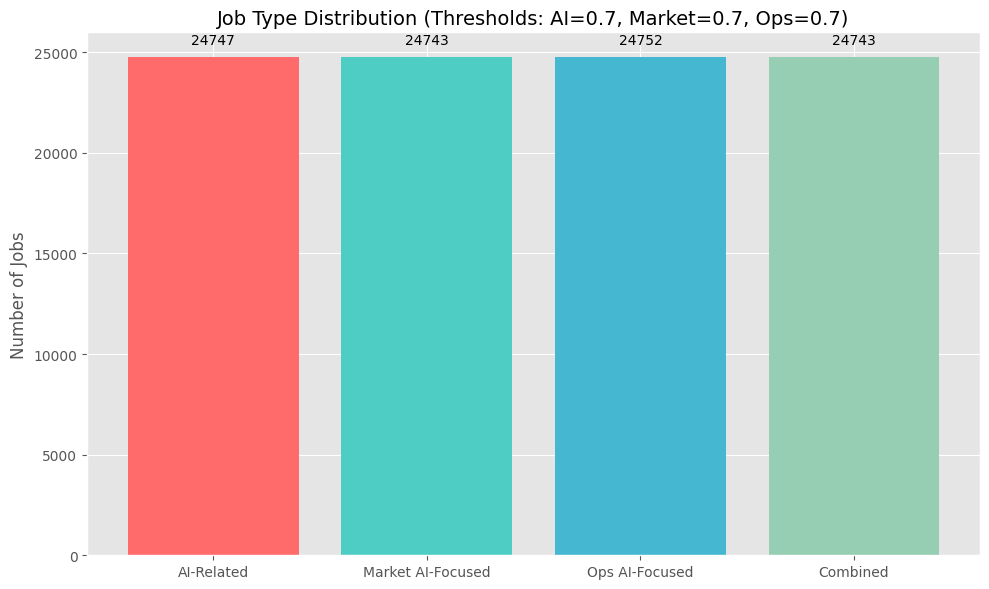

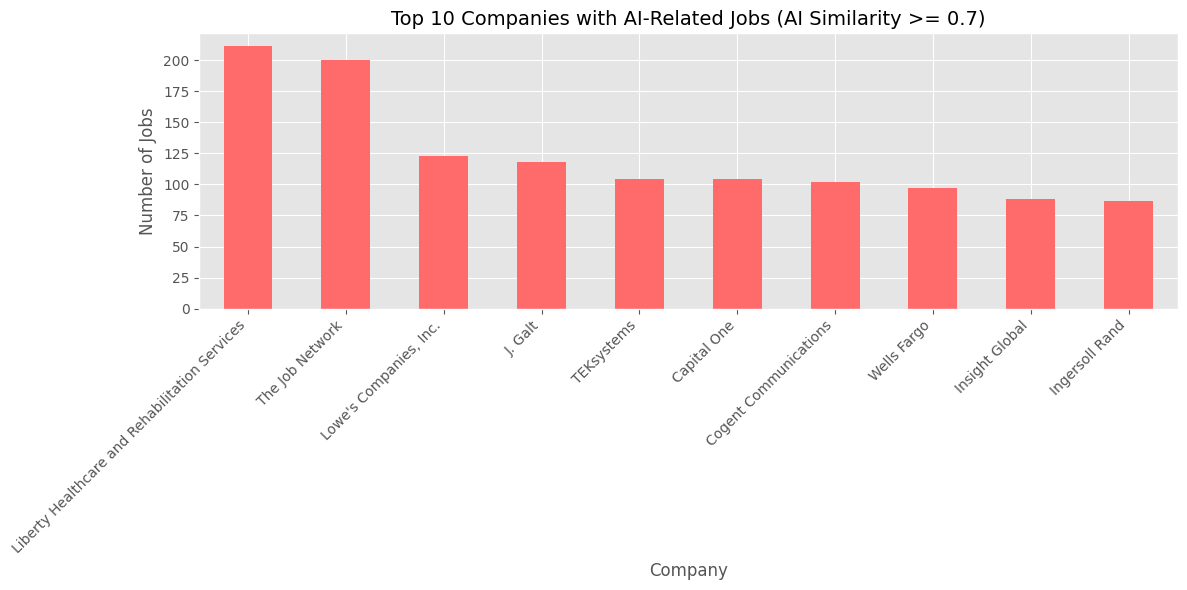

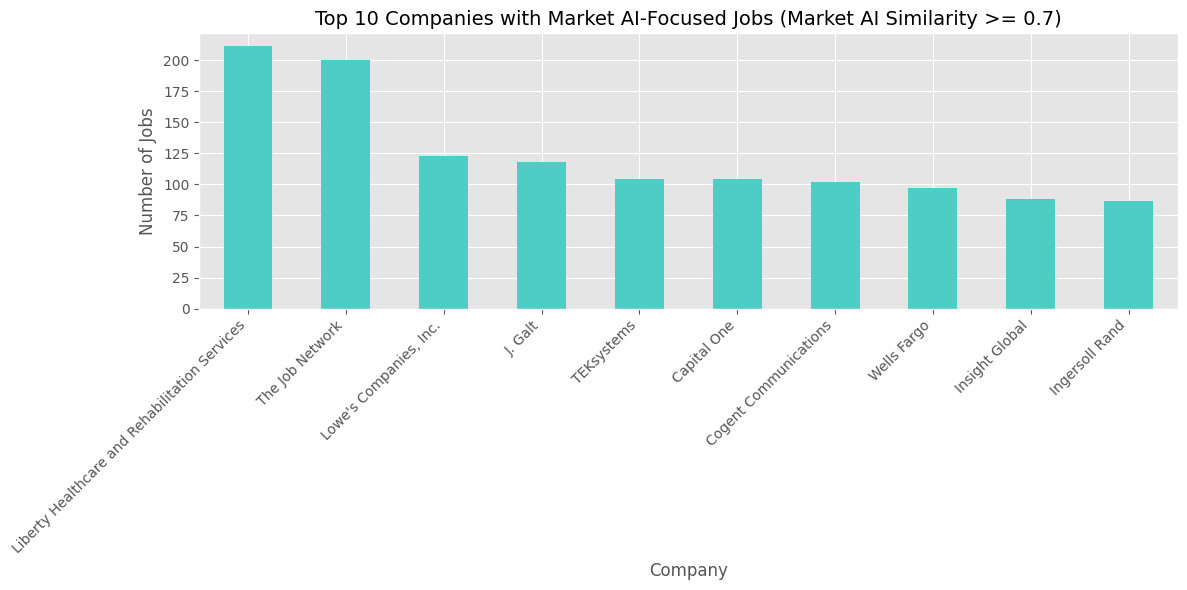

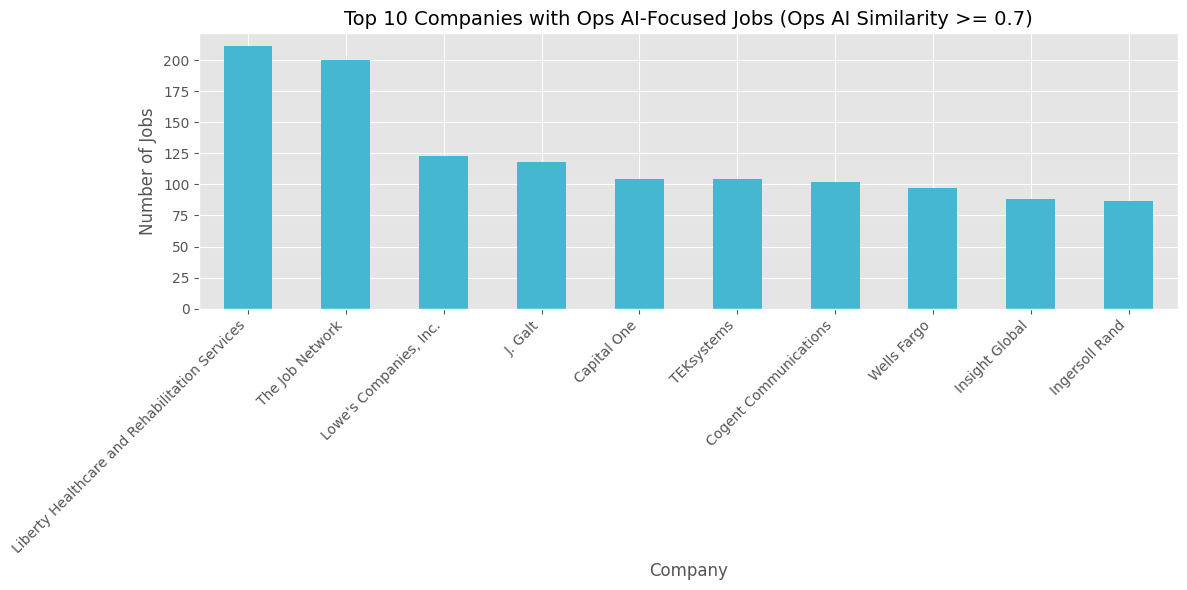

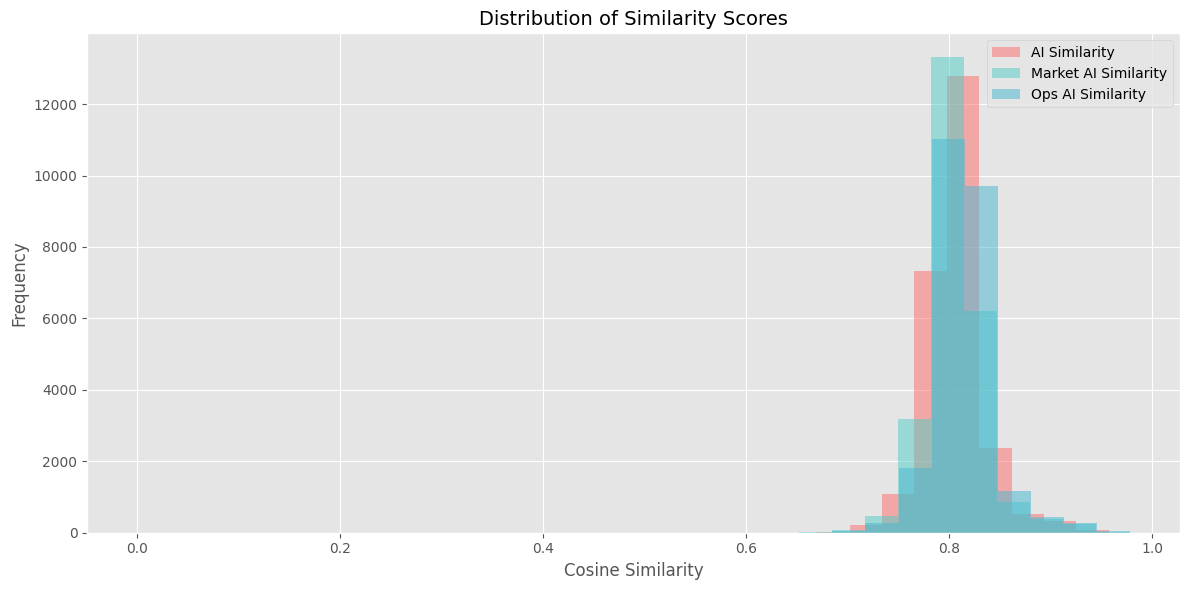

All plots generated. Use the sliders above to adjust the interactive plots.


In [5]:
# Cell 5: Generate Interactive and Descriptive Plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from wordcloud import WordCloud
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

# --- Interactive Plots Section ---
def update_interactive_plots(ai_threshold, market_ai_threshold, operational_ai_threshold):
    # Clear previous output for interactive section
    clear_output(wait=True)
    
    # Filter data based on thresholds
    df_ai = df_processed[df_processed['ai_similarity'] >= ai_threshold]
    df_market = df_processed[df_processed['market_ai_similarity'] >= market_ai_threshold]
    df_ops = df_processed[df_processed['operational_ai_similarity'] >= operational_ai_threshold]
    df_combined = df_processed[
        (df_processed['ai_similarity'] >= ai_threshold) &
        (df_processed['market_ai_similarity'] >= market_ai_threshold) &
        (df_processed['operational_ai_similarity'] >= operational_ai_threshold)
    ]
    
    # AI-Related Jobs
    ai_companies = df_ai['company_name'].value_counts().head(10)
    ai_roles = df_ai['title'].value_counts().head(10)
    ai_wc = WordCloud(width=400, height=300).generate(' '.join(df_ai['clean_text'])) if not df_ai.empty else None
    
    # Marketing AI-Focused Jobs
    market_companies = df_market['company_name'].value_counts().head(10)
    market_roles = df_market['title'].value_counts().head(10)
    market_wc = WordCloud(width=400, height=300).generate(' '.join(df_market['clean_text'])) if not df_market.empty else None
    
    # Operational AI-Focused Jobs
    ops_companies = df_ops['company_name'].value_counts().head(10)
    ops_roles = df_ops['title'].value_counts().head(10)
    ops_wc = WordCloud(width=400, height=300).generate(' '.join(df_ops['clean_text'])) if not df_ops.empty else None
    
    # Combined Filter
    combined_companies = df_combined['company_name'].value_counts().head(10)
    combined_roles = df_combined['title'].value_counts().head(10)
    
    # Create subplots
    fig = make_subplots(rows=4, cols=3,
                        subplot_titles=(
                            'Top AI Companies', 'Top AI Roles', 'AI Word Cloud',
                            'Top Market AI Companies', 'Top Market AI Roles', 'Market AI Word Cloud',
                            'Top Ops AI Companies', 'Top Ops AI Roles', 'Ops AI Word Cloud',
                            'Combined Companies', 'Combined Roles', ''
                        ),
                        specs=[
                            [{'type': 'bar'}, {'type': 'bar'}, {'type': 'domain'}],
                            [{'type': 'bar'}, {'type': 'bar'}, {'type': 'domain'}],
                            [{'type': 'bar'}, {'type': 'bar'}, {'type': 'domain'}],
                            [{'type': 'bar'}, {'type': 'bar'}, {'type': 'domain'}]
                        ])

    # AI-Related Plots
    fig.add_trace(go.Bar(x=ai_companies.index, y=ai_companies.values, name='AI Companies'), row=1, col=1)
    fig.add_trace(go.Bar(x=ai_roles.index, y=ai_roles.values, name='AI Roles'), row=1, col=2)
    if ai_wc:
        fig.add_trace(go.Image(z=ai_wc.to_array()), row=1, col=3)

    # Market AI Plots
    fig.add_trace(go.Bar(x=market_companies.index, y=market_companies.values, name='Market AI Companies'), row=2, col=1)
    fig.add_trace(go.Bar(x=market_roles.index, y=market_roles.values, name='Market AI Roles'), row=2, col=2)
    if market_wc:
        fig.add_trace(go.Image(z=market_wc.to_array()), row=2, col=3)

    # Operational AI Plots
    fig.add_trace(go.Bar(x=ops_companies.index, y=ops_companies.values, name='Ops AI Companies'), row=3, col=1)
    fig.add_trace(go.Bar(x=ops_roles.index, y=ops_roles.values, name='Ops AI Roles'), row=3, col=2)
    if ops_wc:
        fig.add_trace(go.Image(z=ops_wc.to_array()), row=3, col=3)

    # Combined Filter Plots
    fig.add_trace(go.Bar(x=combined_companies.index, y=combined_companies.values, name='Combined Companies'), row=4, col=1)
    fig.add_trace(go.Bar(x=combined_roles.index, y=combined_roles.values, name='Combined Roles'), row=4, col=2)

    # Update layout
    fig.update_layout(height=1200, width=1200, title_text="Interactive Job Analysis Dashboard", showlegend=False)
    fig.update_xaxes(tickangle=45)

    # Display sliders and figure
    display(widgets.VBox([ai_slider, market_slider, ops_slider]))
    display(fig)

# Create interactive widgets
ai_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.7, description='AI Threshold:')
market_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.7, description='Market AI Threshold:')
ops_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.7, description='Ops AI Threshold:')

# Link sliders to update function
interactive_plot = widgets.interactive_output(update_interactive_plots, {
    'ai_threshold': ai_slider,
    'market_ai_threshold': market_slider,
    'operational_ai_threshold': ops_slider
})

# Display interactive section
print("Interactive Plots Section:")
display(interactive_plot)

# --- Descriptive Plots Section ---
def generate_descriptive_plots(df, ai_threshold=0.7, market_ai_threshold=0.7, operational_ai_threshold=0.7):
    # Filter data based on default thresholds
    df_ai = df[df['ai_similarity'] >= ai_threshold]
    df_market = df[df['market_ai_similarity'] >= market_ai_threshold]
    df_ops = df[df['operational_ai_similarity'] >= operational_ai_threshold]
    df_combined = df[
        (df['ai_similarity'] >= ai_threshold) &
        (df['market_ai_similarity'] >= market_ai_threshold) &
        (df['operational_ai_similarity'] >= operational_ai_threshold)
    ]
    
    # Plot 1: Job Type Distribution
    job_counts = {
        'AI-Related': len(df_ai),
        'Market AI-Focused': len(df_market),
        'Ops AI-Focused': len(df_ops),
        'Combined': len(df_combined)
    }
    plt.figure(figsize=(10, 6))
    plt.bar(job_counts.keys(), job_counts.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    plt.title(f'Job Type Distribution (Thresholds: AI={ai_threshold}, Market={market_ai_threshold}, Ops={operational_ai_threshold})', fontsize=14)
    plt.ylabel('Number of Jobs', fontsize=12)
    for i, v in enumerate(job_counts.values()):
        plt.text(i, v + max(job_counts.values()) * 0.02, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    # Plot 2: Top Companies with AI-Related Jobs
    ai_companies = df_ai['company_name'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    ai_companies.plot(kind='bar', color='#FF6B6B')
    plt.title(f'Top 10 Companies with AI-Related Jobs (AI Similarity >= {ai_threshold})', fontsize=14)
    plt.xlabel('Company', fontsize=12)
    plt.ylabel('Number of Jobs', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot 3: Top Companies with Market AI-Focused Jobs
    market_companies = df_market['company_name'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    market_companies.plot(kind='bar', color='#4ECDC4')
    plt.title(f'Top 10 Companies with Market AI-Focused Jobs (Market AI Similarity >= {market_ai_threshold})', fontsize=14)
    plt.xlabel('Company', fontsize=12)
    plt.ylabel('Number of Jobs', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot 4: Top Companies with Operational AI-Focused Jobs
    ops_companies = df_ops['company_name'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    ops_companies.plot(kind='bar', color='#45B7D1')
    plt.title(f'Top 10 Companies with Ops AI-Focused Jobs (Ops AI Similarity >= {operational_ai_threshold})', fontsize=14)
    plt.xlabel('Company', fontsize=12)
    plt.ylabel('Number of Jobs', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot 5: Similarity Score Distributions
    plt.figure(figsize=(12, 6))
    plt.hist(df['ai_similarity'], bins=30, alpha=0.5, label='AI Similarity', color='#FF6B6B')
    plt.hist(df['market_ai_similarity'], bins=30, alpha=0.5, label='Market AI Similarity', color='#4ECDC4')
    plt.hist(df['operational_ai_similarity'], bins=30, alpha=0.5, label='Ops AI Similarity', color='#45B7D1')
    plt.title('Distribution of Similarity Scores', fontsize=14)
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Display descriptive plots
print("\nDescriptive Plots Section:")
generate_descriptive_plots(df_processed, ai_threshold=0.7, market_ai_threshold=0.7, operational_ai_threshold=0.7)

print("All plots generated. Use the sliders above to adjust the interactive plots.")

In [7]:
# Cell 1: Imports and Setup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm
import gc
from wordcloud import WordCloud
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import json

plt.style.use('ggplot')

# Cell 2: Helper Functions
def load_data_in_chunks(file_path, chunk_size=5000):
    return pd.read_csv(file_path, chunksize=chunk_size)

def clean_dictionary_terms(terms):
    return [term.replace("AI", "").replace("ai", "").strip() for term in terms]

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_distilbert_embedding(text, max_length=500):
    if not isinstance(text, str) or not text.strip():
        return np.zeros(768)
    # Split text into chunks if longer than max_length
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_length:
        chunk_embeddings = []
        for i in range(0, len(tokens), max_length):
            chunk = tokens[i:i + max_length]
            chunk_text = tokenizer.convert_tokens_to_string(chunk)
            inputs = tokenizer(chunk_text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model(**inputs)
            chunk_embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy().squeeze())
        return np.mean(chunk_embeddings, axis=0)
    else:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].cpu().numpy().squeeze()

def get_embeddings_in_batches(texts, batch_size=64):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = [get_distilbert_embedding(text) for text in batch_texts]
        embeddings.extend(batch_embeddings)
        gc.collect()
    return np.array(embeddings)

def process_chunk(chunk, market_mean_emb, operational_mean_emb, ai_mean_emb, sample_fraction=0.2):
    sampled_chunk = chunk.sample(frac=sample_fraction, random_state=42)
    print(f"Chunk size: {len(chunk)}, Sampled size: {len(sampled_chunk)}")
    
    embeddings = get_embeddings_in_batches(sampled_chunk['clean_text'].tolist(), batch_size=500)
    
    # Compute similarities
    ai_sim = cosine_similarity(embeddings, ai_mean_emb.reshape(1, -1)).flatten()
    market_sim = cosine_similarity(embeddings, market_mean_emb.reshape(1, -1)).flatten()
    operational_sim = cosine_similarity(embeddings, operational_mean_emb.reshape(1, -1)).flatten()
    
    sampled_chunk['ai_similarity'] = ai_sim
    sampled_chunk['market_similarity'] = market_sim
    sampled_chunk['operational_similarity'] = operational_sim
    sampled_chunk['is_ai_related'] = (ai_sim > 0.7).astype(int)
    sampled_chunk['is_market_focus'] = (market_sim > 0.7).astype(int)
    sampled_chunk['is_operational_focus'] = (operational_sim > 0.7).astype(int)
    sampled_chunk['job_category'] = np.where(market_sim > operational_sim, 'Marketing', 'Operational')
    
    return sampled_chunk[['job_id', 'company_name', 'title', 'clean_text',
                         'ai_similarity', 'market_similarity', 'operational_similarity',
                         'is_ai_related', 'is_market_focus', 'is_operational_focus', 'job_category']]

# Cell 3: Define Dictionaries and Compute Embeddings
market_words = clean_dictionary_terms(["Recommendation", "Pricing", "Advertising", "Chatbot", 
                "Personalization", "Sentiment", "Targeting", "Churn"])
operational_words = clean_dictionary_terms(["Supply Chain", "Inventory", "Logistics", 
                    "Maintenance", "Procurement", "Manufacturing", 
                    "Fulfillment", "Workforce"])
core_ai = ["machine learning", "computer vision", "natural language processing"]

market_embeddings = get_embeddings_in_batches(market_words, batch_size=500)
market_mean_emb = np.mean(market_embeddings, axis=0)
operational_embeddings = get_embeddings_in_batches(operational_words, batch_size=500)
operational_mean_emb = np.mean(operational_embeddings, axis=0)
ai_embeddings = get_embeddings_in_batches(core_ai, batch_size=500)
ai_mean_emb = np.mean(ai_embeddings, axis=0)

# Cell 4: Main Processing
chunk_size = 5000
chunks = load_data_in_chunks('jobs_bert_embeddings.csv', chunk_size)
processed_chunks = []

for i, chunk in enumerate(tqdm(chunks, desc="Processing chunks")):
    processed_chunk = process_chunk(chunk, market_mean_emb, operational_mean_emb, ai_mean_emb, sample_fraction=0.2)
    processed_chunks.append(processed_chunk)
    gc.collect()

df_processed = pd.concat(processed_chunks, ignore_index=True)
print(f"Total sampled jobs processed: {len(df_processed)}")

Processing chunks: 0it [00:00, ?it/s]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 1it [01:50, 110.54s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 2it [03:47, 114.53s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 3it [05:43, 115.15s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 4it [07:41, 116.27s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 5it [09:23, 111.06s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 6it [11:20, 112.94s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 7it [13:17, 114.41s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 8it [15:14, 115.27s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 9it [17:00, 112.40s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 10it [18:56, 113.52s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 11it [20:45, 112.19s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 12it [22:36, 111.81s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 13it [24:30, 112.36s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 14it [26:34, 115.83s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 15it [28:22, 113.42s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 16it [30:15, 113.31s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 17it [32:18, 116.22s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 18it [34:26, 119.72s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 19it [36:31, 121.35s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 20it [38:26, 119.35s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 21it [40:22, 118.44s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 22it [42:32, 121.90s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 23it [44:30, 120.68s/it]

Chunk size: 5000, Sampled size: 1000


Processing chunks: 24it [46:17, 116.54s/it]

Chunk size: 3849, Sampled size: 770


Processing chunks: 25it [48:01, 115.24s/it]

Total sampled jobs processed: 24770


Descriptive Statistics for Similarity Scores:
       ai_similarity  market_similarity  operational_similarity
count   24770.000000       24770.000000            24770.000000
mean        0.806578           0.791388                0.807537
std         0.029176           0.031471                0.029648
min         0.000000           0.000000                0.000000
25%         0.791496           0.776043                0.792888
50%         0.805725           0.790088                0.806435
75%         0.819178           0.803631                0.819063
max         0.957272           0.982463                0.981713

Additional Statistics:
Skewness:
ai_similarity            -1.047476
market_similarity        -0.301162
operational_similarity   -0.692990
dtype: float64
Kurtosis:
ai_similarity             49.975239
market_similarity         36.546552
operational_similarity    48.513713
dtype: float64

Job Category Distribution:
job_category
Operational    24749
Marketing         21
Name: co

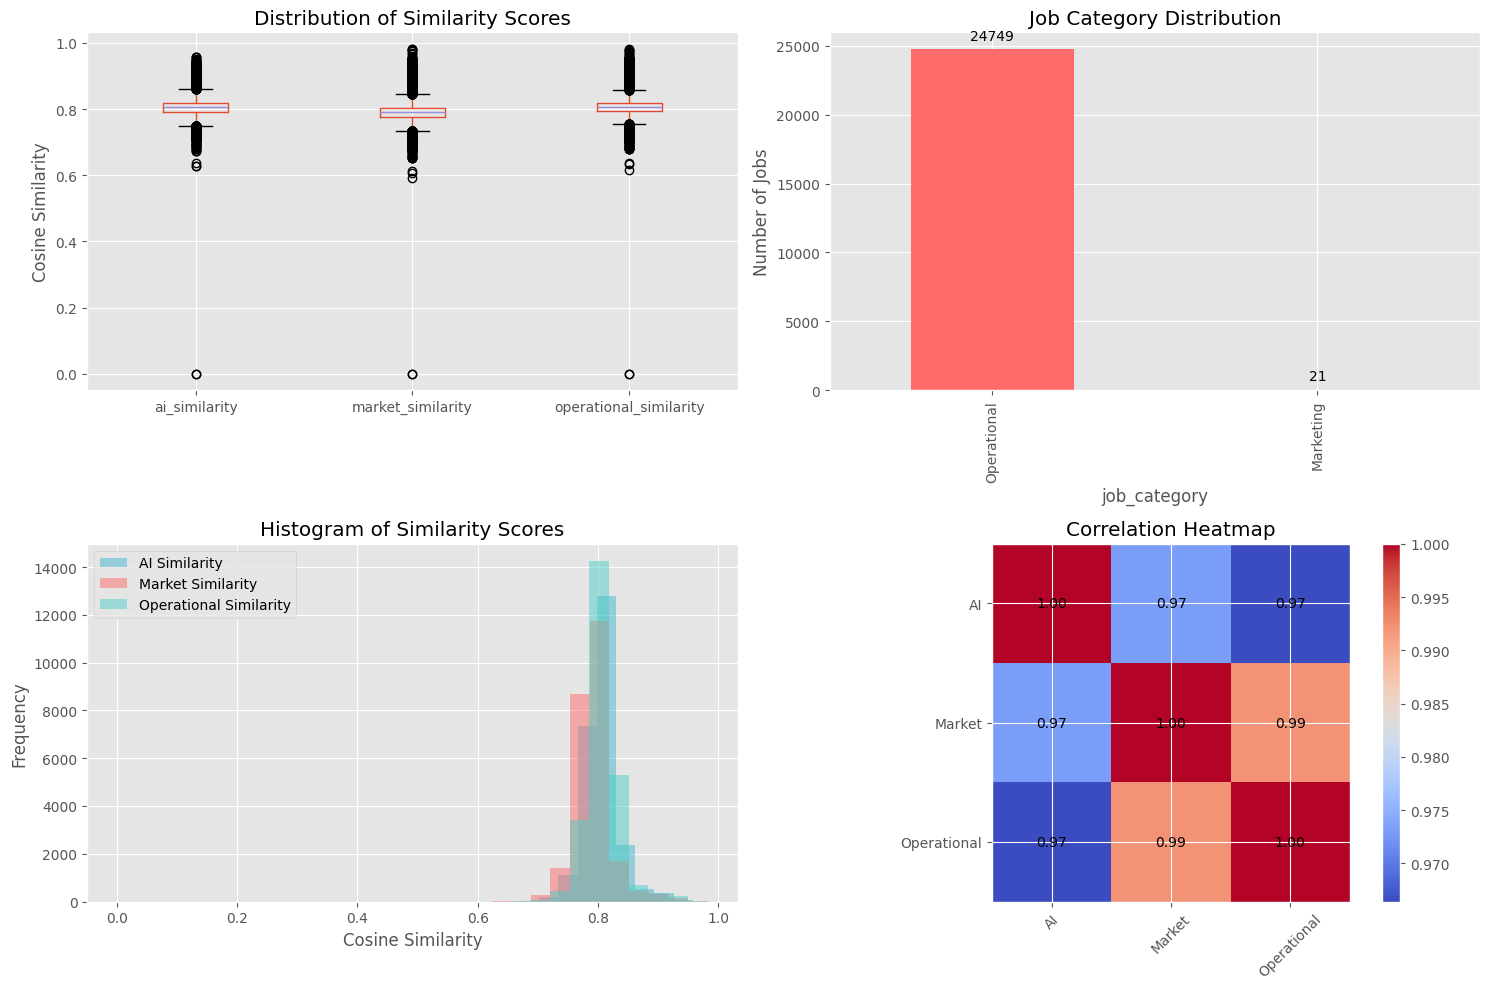

Descriptive statistics saved to 'descriptive_stats.txt'


In [8]:
# Cell 5: Descriptive Statistics
def generate_descriptive_stats(df):
    # Basic summary statistics for similarity scores
    print("Descriptive Statistics for Similarity Scores:")
    similarity_stats = df[['ai_similarity', 'market_similarity', 'operational_similarity']].describe()
    print(similarity_stats)
    
    # Additional statistics
    print("\nAdditional Statistics:")
    print(f"Skewness:\n{df[['ai_similarity', 'market_similarity', 'operational_similarity']].skew()}")
    print(f"Kurtosis:\n{df[['ai_similarity', 'market_similarity', 'operational_similarity']].kurtosis()}")
    
    # Counts of job categories
    print("\nJob Category Distribution:")
    category_counts = df['job_category'].value_counts()
    print(category_counts)
    
    # Counts of jobs meeting similarity thresholds
    print("\nCounts of Jobs by Focus Area (Threshold > 0.7):")
    focus_counts = {
        'AI-Related Jobs': df['is_ai_related'].sum(),
        'Marketing-Focused Jobs': df['is_market_focus'].sum(),
        'Operational-Focused Jobs': df['is_operational_focus'].sum()
    }
    print(pd.Series(focus_counts))
    
    # Correlation between similarity scores
    print("\nCorrelation Matrix of Similarity Scores:")
    correlation_matrix = df[['ai_similarity', 'market_similarity', 'operational_similarity']].corr()
    print(correlation_matrix)
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Box Plot of Similarity Scores
    plt.subplot(2, 2, 1)
    df[['ai_similarity', 'market_similarity', 'operational_similarity']].boxplot()
    plt.title('Distribution of Similarity Scores')
    plt.ylabel('Cosine Similarity')
    
    # 2. Bar Plot of Job Categories
    plt.subplot(2, 2, 2)
    category_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
    plt.title('Job Category Distribution')
    plt.ylabel('Number of Jobs')
    for i, v in enumerate(category_counts):
        plt.text(i, v + max(category_counts) * 0.02, str(v), ha='center', va='bottom')
    
    # 3. Histogram of Similarity Scores
    plt.subplot(2, 2, 3)
    plt.hist(df['ai_similarity'], bins=30, alpha=0.5, label='AI Similarity', color='#45B7D1')
    plt.hist(df['market_similarity'], bins=30, alpha=0.5, label='Market Similarity', color='#FF6B6B')
    plt.hist(df['operational_similarity'], bins=30, alpha=0.5, label='Operational Similarity', color='#4ECDC4')
    plt.title('Histogram of Similarity Scores')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 4. Heatmap of Correlation Matrix
    plt.subplot(2, 2, 4)
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(3), ['AI', 'Market', 'Operational'], rotation=45)
    plt.yticks(range(3), ['AI', 'Market', 'Operational'])
    plt.title('Correlation Heatmap')
    for i in range(3):
        for j in range(3):
            plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
    
    plt.tight_layout()
    plt.show()
    
    # Save descriptive stats to a file
    with open('descriptive_stats.txt', 'w') as f:
        f.write("Descriptive Statistics for Similarity Scores:\n")
        f.write(similarity_stats.to_string())
        f.write("\n\nAdditional Statistics:\n")
        f.write(f"Skewness:\n{df[['ai_similarity', 'market_similarity', 'operational_similarity']].skew().to_string()}\n")
        f.write(f"Kurtosis:\n{df[['ai_similarity', 'market_similarity', 'operational_similarity']].kurtosis().to_string()}\n")
        f.write("\nJob Category Distribution:\n")
        f.write(category_counts.to_string())
        f.write("\n\nCounts of Jobs by Focus Area (Threshold > 0.7):\n")
        f.write(pd.Series(focus_counts).to_string())
        f.write("\n\nCorrelation Matrix of Similarity Scores:\n")
        f.write(correlation_matrix.to_string())

# Run the descriptive stats function
generate_descriptive_stats(df_processed)
print("Descriptive statistics saved to 'descriptive_stats.txt'")